# Supervised Generative Dog Network
Do GANs (Generative Adversarial Networks) memorize images or generalize images? This is a heavily debated question and it's hard to determine what a GAN is actually doing. If a GAN memorizes images, then choosing random seeds in latent space creates basic blends of training images. If a GAN generalizes images, then choosing random seeds produces exciting images that utilize patterns and components from training images but are not simple blend images.

In this kernel, using supervision, we force a Generative Network (half a GAN) to memorize images. (A full Memorizing GAN is posted [here][5]). We then demonstrate that moving in a straight line through latent space produces a sequence of basic blended images instead of producing a sequence of exciting generalized images. (Exciting latent walk images can be seen [here][6]). (More information about latent walks can be found [here][4] in section 6.1)

# Load and Crop Images
Thank you Paulo Pinto for posting code to retrieve bounding box info [here][3]. Using bounding box information, we can crop dogs from the images. Below we can either create crops with dogs only or randomly crop full images using boolean `DogsOnly = True`.

[1]: https://www.kaggle.com/cdeotte/dog-autoencoder
[2]: https://www.kaggle.com/c/generative-dog-images/discussion/98183
[3]: https://www.kaggle.com/paulorzp/show-annotations-and-breeds
[4]: https://arxiv.org/abs/1511.06434
[5]:https://www.kaggle.com/cdeotte/dog-memorizer-gan
[6]: https://www.kaggle.com/c/generative-dog-images/discussion/98719

# 監視付き生成犬ネットワーク
GAN（Generative Adversarial Networks）は、画像を記憶しますか、それとも一般化しますか？これはかなり議論されている質問であり、GANが実際に何をしているのかを判断するのは困難です。 GANが画像を記憶している場合、潜在空間でランダムシードを選択すると、トレーニング画像の基本的なブレンドが作成されます。 GANが画像を一般化する場合、ランダムシードを選択すると、トレーニング画像からパターンとコンポーネントを利用するエキサイティングな画像が生成されますが、単純なブレンド画像ではありません。

このカーネルでは、監視を使用して、画像を暗記するように生成ネットワーク（半分GAN）に強制します。 （完全な暗記GANが掲載されています[ここ] [5]）。次に、潜在空間を直線的に移動すると、一連の基本的な混合画像が一連のエキサイティングな一般化画像を生成するのではなく生成されることを示します。 （エキサイティングな潜像が見られる[ここ] [6]）。 （潜在散歩に関するより多くの情報はセクション6.1の[ここ] [4]で見つけることができます）

＃画像の読み込みとトリミング
バウンディングボックスの情報を取得するためのコードを投稿してくれてありがとうPaulo Pinto [ここ] [3]。バウンディングボックスの情報を使って、画像から犬を切り取ることができます。以下では、犬だけでクロップを作成するか、ブール型の `DogsOnly = True`を使用してフルイメージをランダムにクロップすることができます。

[1]：https://www.kaggle.com/cdeotte/dog-autoencoder
[2]：https://www.kaggle.com/c/generative-dog-images/discussion/98183
[3]：https://www.kaggle.com/paulorzp/show-annotations-and-breeds
[4]：https://arxiv.org/abs/1511.06434
[5]：https：//www.kaggle.com/cdeotte/dog-memorizer-gan
[6]：https://www.kaggle.com/c/generative-dog-images/discussion/98719

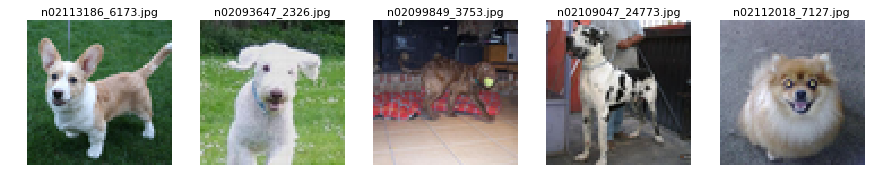

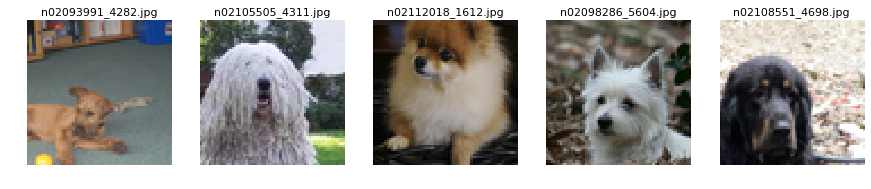

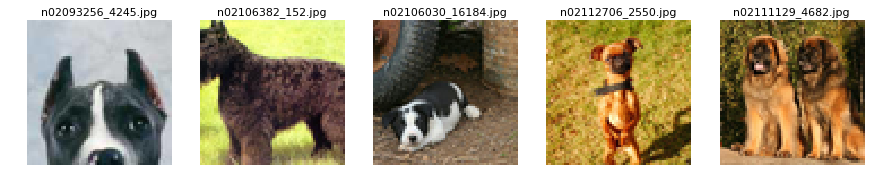

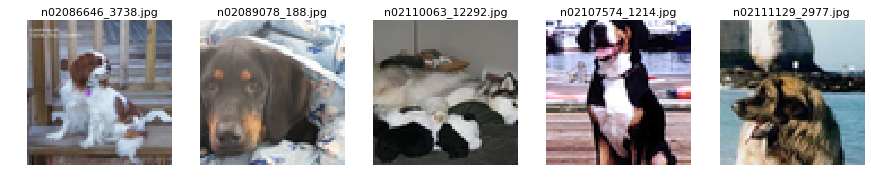

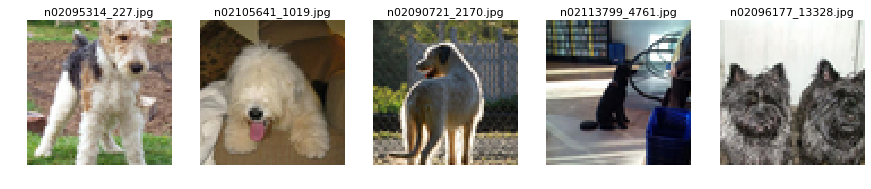

In [1]:
ComputeLB = False
DogsOnly = False

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = '../input/generative-dog-images/'
if not ComputeLB: ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annotation/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
                
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20000),10000)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))  
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        #if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

# Build Generative Network
This generative network is the decoder from my autoencoder kernel [here][1], and is half of my Memorizing GAN [here][2]

[1]: https://www.kaggle.com/cdeotte/dog-autoencoder
[2]: https://www.kaggle.com/cdeotte/dog-memorizer-gan

＃ジェネリックネットワークを構築する
この生成的ネットワークは私のオートエンコーダカーネル[ここ] [1]のデコーダであり、私のMemorizing GAN [ここ] [2]の半分です。

[1]：https://www.kaggle.com/cdeotte/dog-autoencoder
[2]：https://www.kaggle.com/cdeotte/dog-memorizer-gan

In [2]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [3]:
# BUILD GENERATIVE NETWORK
direct_input = Input((10000,))
x = Dense(2048, activation='elu')(direct_input)
x = Reshape((8,8,32))(x)
x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
decoder = Model(direct_input, decoded)
decoder.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy')

# DISPLAY ARCHITECTURE
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              20482048  
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         36992     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 64)        0         
__________

# Train Generative Network

In [4]:
# TRAINING DATA
idx = np.random.randint(0,idxIn,10000)
train_y = imagesIn[idx,:,:,:]/255.
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1

In [5]:
# TRAIN NETWORK
lr = 0.005
for k in range(50):
    annealer = LearningRateScheduler(lambda x: lr)
    h = decoder.fit(train_X, train_y, epochs = 10, batch_size=256, callbacks=[annealer], verbose=0)
    if k%5==4: print('Epoch',(k+1)*10,'/500 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.54: lr = 0.001

Epoch 50 /500 - loss = 0.5394598940849304
Epoch 100 /500 - loss = 0.5358363786697388
Epoch 150 /500 - loss = 0.5350238813400269
Epoch 200 /500 - loss = 0.5344804408073426
Epoch 250 /500 - loss = 0.5341346699714661
Epoch 300 /500 - loss = 0.5338462404251099
Epoch 350 /500 - loss = 0.533694758605957
Epoch 400 /500 - loss = 0.5335506708145141
Epoch 450 /500 - loss = 0.5334618333816529
Epoch 500 /500 - loss = 0.5333158920288086


# Delete Training Images
Our generative network has now memorized all the training images. We will now delete the training images. As per the rules [here][1], our generative network can now "stand alone" without the assistance of training images.

[1]: https://www.kaggle.com/c/generative-dog-images/discussion/98183

＃トレーニング画像を削除する
私たちの生成的ネットワークは現在、すべてのトレーニング画像を記憶しています。トレーニング画像を削除します。規則[ここ] [1]に従って、私たちの生成的ネットワークは、トレーニング画像の助けを借りずに「独立」することができます。

[1]：https://www.kaggle.com/c/generative-dog-images/discussion/98183

In [6]:
del train_X, train_y, imagesIn

# Generate Random Dogs
But inputting a random vector of length 10000 into our generative network, we will get out a random dog image. This is how a VAE or GAN works. 

＃ランダム犬を生成する
しかし、長さ10000のランダムなベクトルを生成ネットワークに入力すると、ランダムな犬の画像が得られます。これがVAEまたはGANのしくみです。

Generate Random Dogs


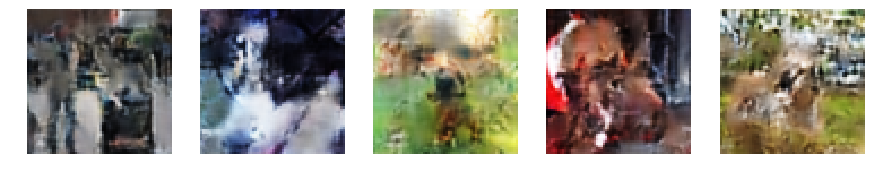

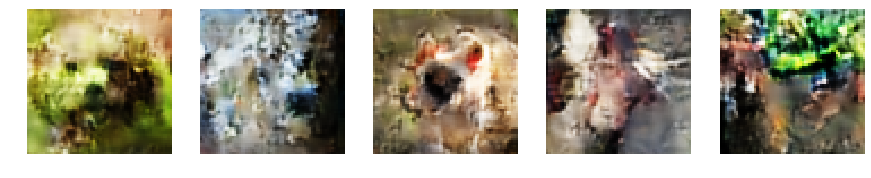

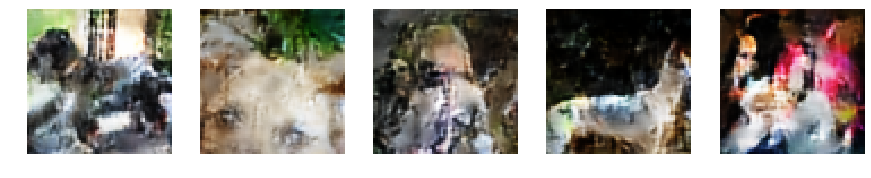

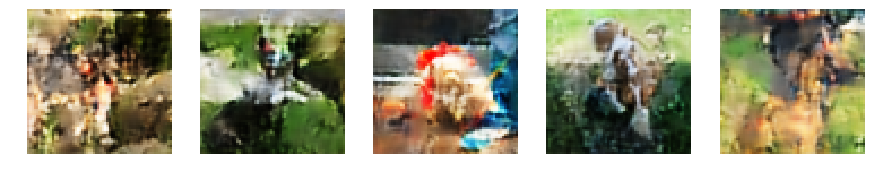

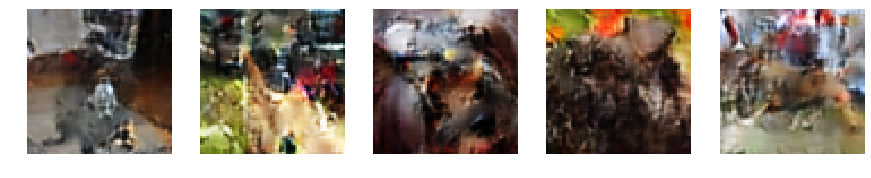

In [7]:
print('Generate Random Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        xx[np.random.randint(10000)] = 0.75
        #xx[np.random.randint(10000)] = 0.25
        xx = xx/(np.sqrt(xx.dot(xx.T)))
        plt.subplot(1,5,j+1)
        img = decoder.predict(xx.reshape((-1,10000)))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Recall from Memory Dogs
Similar to a VAE or GAN, we can get a random image from our generative network by inputting a random vector of length 10000. What is special about our network is that we used supervised training to organize memory such that inputting the vector `x1 = [1, 0, ,0, ..., 0, 0]` will output the memorized version of training image 1. And `x2 = [0, 1, 0, ..., 0, 0]` will output memorized training image 2. Below we display 25 memorized images.

＃Memory Dogsから思い出す
VAEやGANと同様に、長さ10000のランダムベクトルを入力することで、生成ネットワークからランダムな画像を取得できます。ベクトルを入力するように、教師付きトレーニングを使用してメモリを整理しました。 1、0、、0、...、0、0] `は学習画像1の記憶されたバージョンを出力します。そして` x2 = [0、1、0、...、0、0] `は記憶された学習を出力しますimage 2.以下に25個の記憶された画像を表示します。

Recall from Memory Dogs


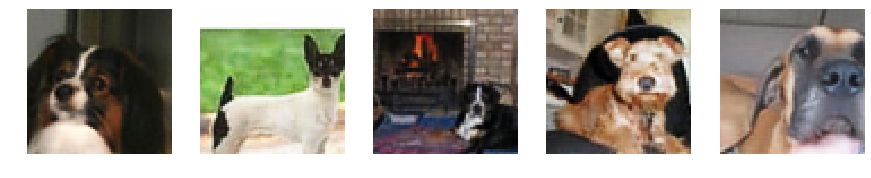

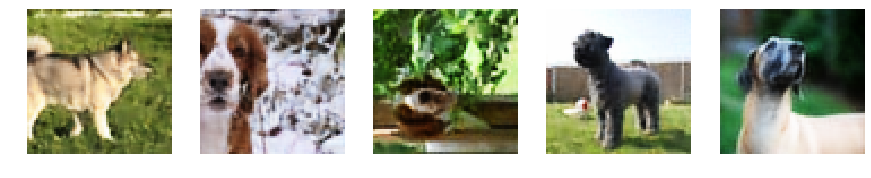

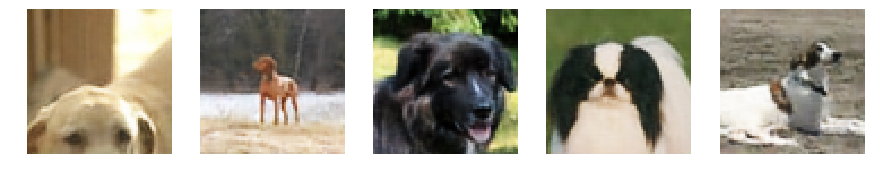

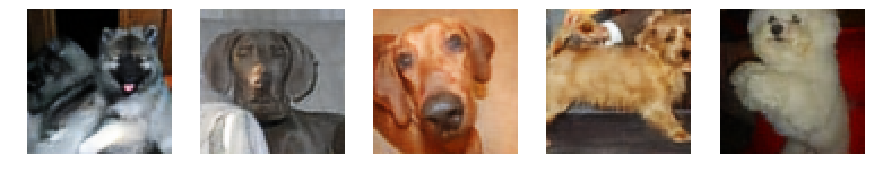

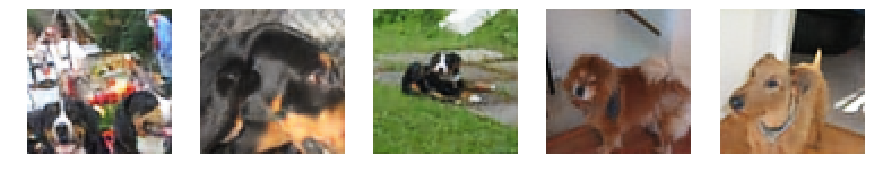

In [8]:
print('Recall from Memory Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = decoder.predict(xx.reshape((-1,10000)))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Walking in the Latent Space
A test to determine if your GAN memorized or generalized is to walk in latent space. (More info about latent space in my first kernel [here][3]). Starting from one seed `x1`, move in a straight line through latent space to seed `x2`. For each intermediate seed, output the assoicated generated image. If the images are simple pixel blends of image `x1` with `x2` then most likely you're memorizing. If all the intermediate images are valid images themselves (and don't look like simple blends) then most likely you're generalizing. See section 6.1 [here][2] for more info.

The following example from the cited paper above shows that walking in latent space from one bedroom image to another bedroom image produces valid intermediate images. Notice how the intermediate images are not simple pixel blends. Instead they conceptually change objects on the walls through a series of different valid objects.

![image](http://playagricola.com/Kaggle/walk7319.png)

Because our GAN's memory is organized such that training image 1 can be retrieved with seed `x1 = [1, 0, 0, ...,0, 0]` and training image 2 with seed `x2 = [0, 1, 0, ..., 0, 0]`, we will walk from training image 1 to training image 2. We just need to set one vector element as `theta` (where `0 <= theta <= 1`) and the other as `1-theta` then we get `theta`% of image 1 and `(1-theta)`% of image 2. Then we vary `theta` from 0 to 1.

In the sequences below, you will observe akward middle images. If we perform the following experiment with a GAN that learns to **generalize** then we won't see middle images of awkward blends. A well designed adversarial discriminative network could insure that every image outputted by our generative network is a valid realistic dog image. Currently, our supervised GN only made sure that the 10000 images that it memorized are valid. A full **generalizing** GAN can output millions of valid pictures! And it can make smooth transistions between input seeds. See [here][1] for a video example.

[1]: https://towardsdatascience.com/do-gans-really-model-the-true-data-distribution-or-are-they-just-cleverly-fooling-us-d08df69f25eb
[2]: https://arxiv.org/abs/1511.06434
[3]: https://www.kaggle.com/cdeotte/dog-autoencoder

＃潜在空間を歩く
あなたのGANが暗記されているのか一般化されているのかを判断するためのテストは、潜在空間を歩くことです。 （私の最初のカーネルの潜在空間に関する詳細[ここ] [3]）。 １つの種「ｘ１」から始めて、潜在空間を通って直線的に動いて種「ｘ２」に移動する。各中間シードについて、関連付けられた生成画像を出力します。画像が画像 `x1`と` x2`の単純なピクセル混合であるならば、たぶん記憶しているでしょう。すべての中間画像がそれ自体有効な画像である（そして単純なブレンドのように見えない）ならば、おそらく一般化しているでしょう。詳しくは6.1 [here] [2]をご覧ください。

上記の引用論文からの以下の例は、ある寝室の画像から別の寝室の画像への潜在空間内を歩くことが有効な中間画像を生成することを示している。中間画像が単純なピクセルブレンドではないことに注目してください。代わりに、それらは概念的に一連の異なる有効なオブジェクトを通して壁の上のオブジェクトを変えます。

！[画像]（http://playagricola.com/Kaggle/walk7319.png）

我々のGANのメモリはトレーニング画像1が種 `x1 = [1、0、0、...、0、0]`で、トレーニング画像2が種 `x2 = [0、1、0]で取り出せるように構成されているから、…、０，０］｀、訓練画像１から訓練画像２へと進む。１つのベクトル要素を「theta」（ここで、「０ ＜＝ theta ＜＝ １」）として設定し、もう１つを設定するだけでよい。 `1-theta`として、画像1の` theta`％と画像2の `（1-theta）`％を得ます。それから `theta`を0から1まで変化させます。

以下のシーケンスでは、Akwardの中央の画像を観察します。 **一般化**を習得したGANで次の実験を実行すると、厄介なブレンドの真ん中の画像は表示されません。うまく設計された敵対的識別ネットワークは、我々の生成的ネットワークによって出力された全ての画像が有効な現実的な犬の画像であることを保証することができる。現在、私たちの監督下のGNはそれが記憶した10000の画像が有効であることを確認するだけでした。完全な**一般化<**> GANは何百万もの有効な写真を出力することができます！そしてそれは入力シード間のスムーズな遷移を作ることができます。ビデオの例については[ここ] [1]を参照してください。

[1]：https://towardsdatascience.com/do-gans-really-model-the-true-data-distribution-or-are-they-just-cleverly-fooling-us-d08df69f25eb
[2]：https://arxiv.org/abs/1511.06434
[3]：https://www.kaggle.com/cdeotte/dog-autoencoder

Walk in Latent Space


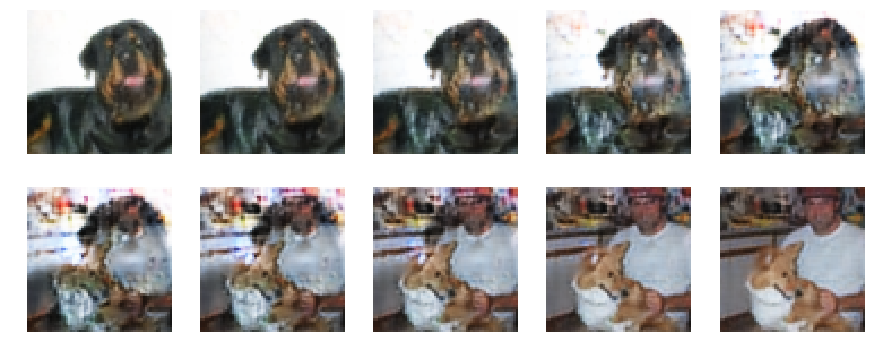

Walk in Latent Space


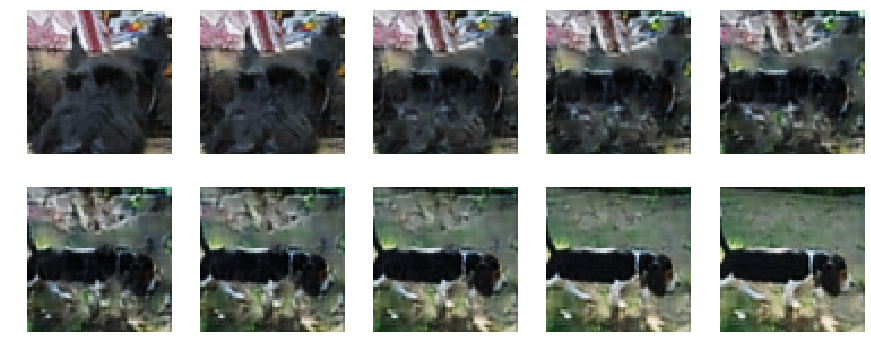

Walk in Latent Space


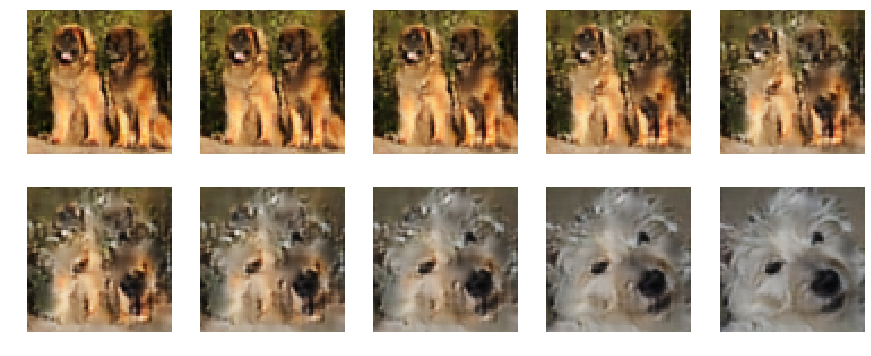

In [9]:
for k in range(3):
    print('Walk in Latent Space') 
    a = np.random.randint(10000)
    b = np.random.randint(10000)
    plt.figure(figsize=(15,6))
    for j in range(10):
        xx = np.zeros((10000))
        theta = j/9
        xx[a] = theta; xx[b] = 1-theta
        xx = xx/(np.sqrt(xx.dot(xx.T)))
        plt.subplot(2,5,j+1)
        img = decoder.predict(xx.reshape((-1,10000)))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Submit to Kaggle
The problem with generative methods that memorize training images is that it allows the submission of essentially original images. For example submit 99% original image 1 with 1% original image 2 added. Then essentially we would be submitting image 1. Furthermore the MiFID metric doesn't recognize that cropped images are the same as original images. Therefore a **memorizing** generative method using cropped images can score very good LB.

＃Kaggleに送信する
トレーニング画像を記憶する生成方法の問題は、それが本質的にオリジナルの画像の提出を可能にすることである。たとえば、99％のオリジナル画像1に1％のオリジナル画像2を追加して送信します。それから、基本的に私たちは画像1を提出することになります。さらにMiFIDメトリックはトリミングされた画像がオリジナルの画像と同じであることを認識しません。それゆえ、トリミングされた画像を使用する＜**＞記憶する＜**＞生成方法は、非常に良いLBを採点することができる。

In [10]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
for k in range(10000):
    # GENERATE NEW DOGS
    xx = np.zeros((10000))
    xx[np.random.randint(10000)] = 0.99
    xx[np.random.randint(10000)] = 0.01
    img = decoder.predict(xx.reshape((-1,10000)))
    img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
    # SAVE TO ZIP FILE  
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()

# Calculate LB Score
If you wish to compute LB, you must add the LB metric dataset [here][1] to this kernel and change the boolean variable to `True` in the first code cell block. If you wish to submit `Images.zip` to Kaggle, then you must remove the LB metric dataset and change the boolean variable to `False`.

[1]: https://www.kaggle.com/wendykan/dog-face-generation-competition-kid-metric-input

＃LBスコアを計算
LBを計算したい場合は、LBメトリクスデータセット[here] [1]をこのカーネルに追加し、最初のコードセルブロックでブール変数をTrueに変更する必要があります。 `Images.zip`をKaggleに送信したい場合は、LBメトリックデータセットを削除してブール変数を` False`に変更する必要があります。

[1]：https://www.kaggle.com/wendykan/dog-face-generation-competition-kid-metric-input

In [11]:
from __future__ import absolute_import, division, print_function
import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2

In [12]:
if ComputeLB:
    
    # UNCOMPRESS OUR IMGAES
    with zipfile.ZipFile("../working/images.zip","r") as z:
        z.extractall("../tmp/images2/")

    # COMPUTE LB SCORE
    m2 = []; s2 =[]; f2 = []
    user_images_unzipped_path = '../tmp/images2/'
    images_path = [user_images_unzipped_path,'../input/generative-dog-images/all-dogs/all-dogs/']
    public_path = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

    fid_epsilon = 10e-15

    fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
    distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
    print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
            fid_value_public /(distance_public + fid_epsilon))
    
    # REMOVE FILES TO PREVENT KERNEL ERROR OF TOO MANY FILES
    ! rm -r ../tmp